In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
from scipy.stats import lognorm
from scipy.stats import norm
import math
#import seaborn as sns
from random import sample
import pandas 
import src.test_strategies
print(scipy.__version__)
import statistics

1.4.1


In [2]:
graph = {}
with open('fb_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
G = nx.from_dict_of_dicts(graph)

Constants

In [3]:
R_0 = 2.8
TOTAL_EDGES = G.number_of_edges()
TOTAL_NODES = len(G)
AVERAGE_NUM_EDGES = 2*TOTAL_EDGES/TOTAL_NODES
TOTAL_DURATION_OF_INFECTION = 14
HOSPITALIZED_DURATION_OF_INFECTION = 20
ADJUSTED_R_0 = R_0/(AVERAGE_NUM_EDGES*TOTAL_DURATION_OF_INFECTION)
DIST_INCUBATION_MEAN = 1.621
DIST_INCUBATION_SD = 0.418
PROB_ALWAYS_ASYMPTOMATIC = 0.2

DIST_HOSPITAL_MEAN = 10
DIST_HOSPITAL_SD = 1
PROB_HOSPITAL= 0.1755
PROB_DEATH_IF_HOSPITAL = 0.01

NUM_FIRST_INFECTED = 10
NUMBER_OF_TESTS = 50

In [4]:
for i in range(len(G.nodes)):
    G.nodes[i]["status"] = "S"
nx.set_node_attributes(G, False, name = "confirmed positive")
nx.set_node_attributes(G, False, name = "tested")
nx.set_node_attributes(G, False, name = "infected")
nx.set_node_attributes(G, None, name = "onset of symptoms")
nx.set_edge_attributes(G, name = "weight", values = 1)

node_deg_pairs = list(G.degree())
node_deg_pairs.sort(key = lambda x: x[1], reverse = True)
node_degrees = [node for node, deg in node_deg_pairs]
G.graph['node_degrees'] = node_degrees

In [49]:
G.nodes.data()

NodeDataView({0: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 1: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 2: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 3: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 4: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 5: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 6: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 7: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset of symptoms': None}, 8: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False, 'onset

In [5]:
quarantine_infectivity = 0.1
confirmed_negative_infectivity = 1
prev_tested = [set(), set(), set(), set(), set()]
ind_to_prev_tested = 0

In [39]:
def run_iteration(G, test_allocation = {'random': 0, 'high_connect': 0, 'pooled': 0, 'most_infected':0}, NUMBER_OF_TESTS = NUMBER_OF_TESTS):
    """
    Input: G is the graph
    test_allocation is the percentage of tests allocated to each strategy,
    the strategies are in this order random, high connected, pooled, and most
    infected. The total must add up to one.
    """
    weight = nx.get_edge_attributes(G, "weight")
    
    S_n = [n for n,v in G.nodes(data=True) if v['status'] == 'S']
    E_n = [n for n,v in G.nodes(data=True) if v['status'] == 'E']
    I_n = [n for n,v in G.nodes(data=True) if v['status'] == 'I']
    H_n = [n for n,v in G.nodes(data=True) if v['status'] == 'H']
    for i in I_n:
        for neighbor in G.neighbors(i):
            if G.nodes[neighbor]["status"] == "S":
                # Multiplying by the weight of the edge is supposed to model decreased 
                # contact after a person is in quarentine
                if random.random() < ADJUSTED_R_0*G[i][neighbor]["weight"]:
                    G.nodes[neighbor]["status"] = "E"
                    G.nodes[neighbor]["days_since_E"] = 0
        
    for e in E_n:
        G.nodes[e]["days_since_E"] += 1
        days_since_E = G.nodes[e]["days_since_E"]
        if days_since_E == TOTAL_DURATION_OF_INFECTION: # if you've been asymp for 14 days, you recover
            G.nodes[e]["status"] = "R"
        prob = lognorm.pdf(days_since_E, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN)) * (1-PROB_ALWAYS_ASYMPTOMATIC)
        if random.random() < prob:
            G.nodes[e]["status"] = "I"
            G.nodes[e]["days_since_I"] = 0
            G.nodes[e]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
    for i in I_n:
        G.nodes[i]["days_since_E"] += 1
        G.nodes[i]["days_since_I"] += 1
        days_since_I = G.nodes[i]["days_since_I"]
        # Added social distancing after 5 days of being infected
        if days_since_I > G.nodes[i]["onset of symptoms"]:
            cn_edges = G.edges(i)
            cn_edges = (e if e in weight else (e[1], e[0]) for e in cn_edges)
            updated_edges = {e: weight[e]*quarantine_infectivity for e in cn_edges}
            nx.set_edge_attributes(G, name = "weight", values = updated_edges)
        dist = norm(DIST_HOSPITAL_MEAN, DIST_HOSPITAL_SD) 
        prob = dist.pdf(days_since_I) * PROB_HOSPITAL
        if random.random() < prob:
            G.nodes[i]["status"] = "H"
            G.nodes[i]["days_since_H"] = 0
        if G.nodes[i]["days_since_E"] >= TOTAL_DURATION_OF_INFECTION:
            G.nodes[i]["status"] = "R"
    for h in H_n:
        G.nodes[h]["days_since_H"] += 1
        G.nodes[h]["days_since_E"] += 1
        if G.nodes[h]["days_since_E"] == TOTAL_DURATION_OF_INFECTION:
            if random.random() < PROB_DEATH_IF_HOSPITAL:
                G.nodes[h]["status"] = "D"
            else:
                G.nodes[h]["status"] = "R"
                
    # If we do testing, we now update the nodes depending on the test passed in 
    if test_allocation['random'] + test_allocation['pooled'] + test_allocation['most_infected'] + test_allocation['high_connect'] > 1:
        raise NameError('cannot allocate more that 100% of tests')
    if test_allocation['random'] != 0:
        src.test_strategies.test_strat_random_sample(G, int(NUMBER_OF_TESTS*test_allocation['random']))
        print(int(NUMBER_OF_TESTS*test_allocation['random']))
    if test_allocation['high_connect'] != 0:
        prev_t = prev_tested[0].union(prev_tested[1], prev_tested[2], prev_tested[3], prev_tested[4])
        (tested, num_tested, extra_tests) = src.test_strategies.test_strat_high_contact(G, 150, int(NUMBER_OF_TESTS*test_allocation['high_connect']), prev_t)
        print(int(NUMBER_OF_TESTS*test_allocation['high_connect']))
        global ind_to_prev_tested
        prev_tested[ind_to_prev_tested] = set(tested)
        ind_to_prev_tested = (ind_to_prev_tested + 1)  % 5
    if test_allocation['pooled'] != 0:
        #TODO: add a value that takes number of tests for pooled testing
        src.test_strategies.test_strat_pool_family(G)
    if test_allocation['most_infected'] != 0:
        src.test_strategies.test_strat_most_infected(G,int(NUMBER_OF_TESTS*test_allocation['most_infected']))
        print(int(NUMBER_OF_TESTS*test_allocation['most_infected']))

In [7]:
# Choose 10 people at random to be infected initially
T = G.copy()
first_infected = random.sample(list(T.nodes()), NUM_FIRST_INFECTED)

In [8]:
# Copy the graph 4 times so we can use one clean copy for each modeling iteration 
T = G.copy()
T_1 = G.copy() 
T_2 = G.copy()
T_3 = G.copy()
T_4 = G.copy()
# Also make each copy reflect the infected status from the initial infections
for i in first_infected:
    T.nodes[i]["status"] = "I"
    T.nodes[i]["days_since_E"] = 0
    T.nodes[i]["days_since_I"] = 0
    T.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
for i in first_infected:
    T_1.nodes[i]["status"] = "I"
    T_1.nodes[i]["days_since_E"] = 0
    T_1.nodes[i]["days_since_I"] = 0
    T_1.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
for i in first_infected:
    T_2.nodes[i]["status"] = "I"
    T_2.nodes[i]["days_since_E"] = 0
    T_2.nodes[i]["days_since_I"] = 0
    T_2.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
for i in first_infected:
    T_3.nodes[i]["status"] = "I"
    T_3.nodes[i]["days_since_E"] = 0
    T_3.nodes[i]["days_since_I"] = 0
    T_3.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
for i in first_infected:
    T_4.nodes[i]["status"] = "I"
    T_4.nodes[i]["days_since_E"] = 0
    T_4.nodes[i]["days_since_I"] = 0
    T_4.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]

In [9]:
pos=nx.spring_layout(T)

In [ ]:
plt.close('all')

KeyboardInterrupt: 

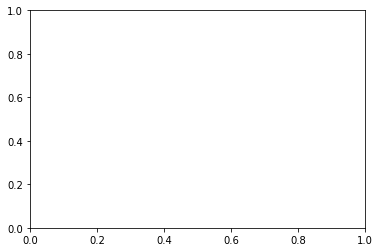

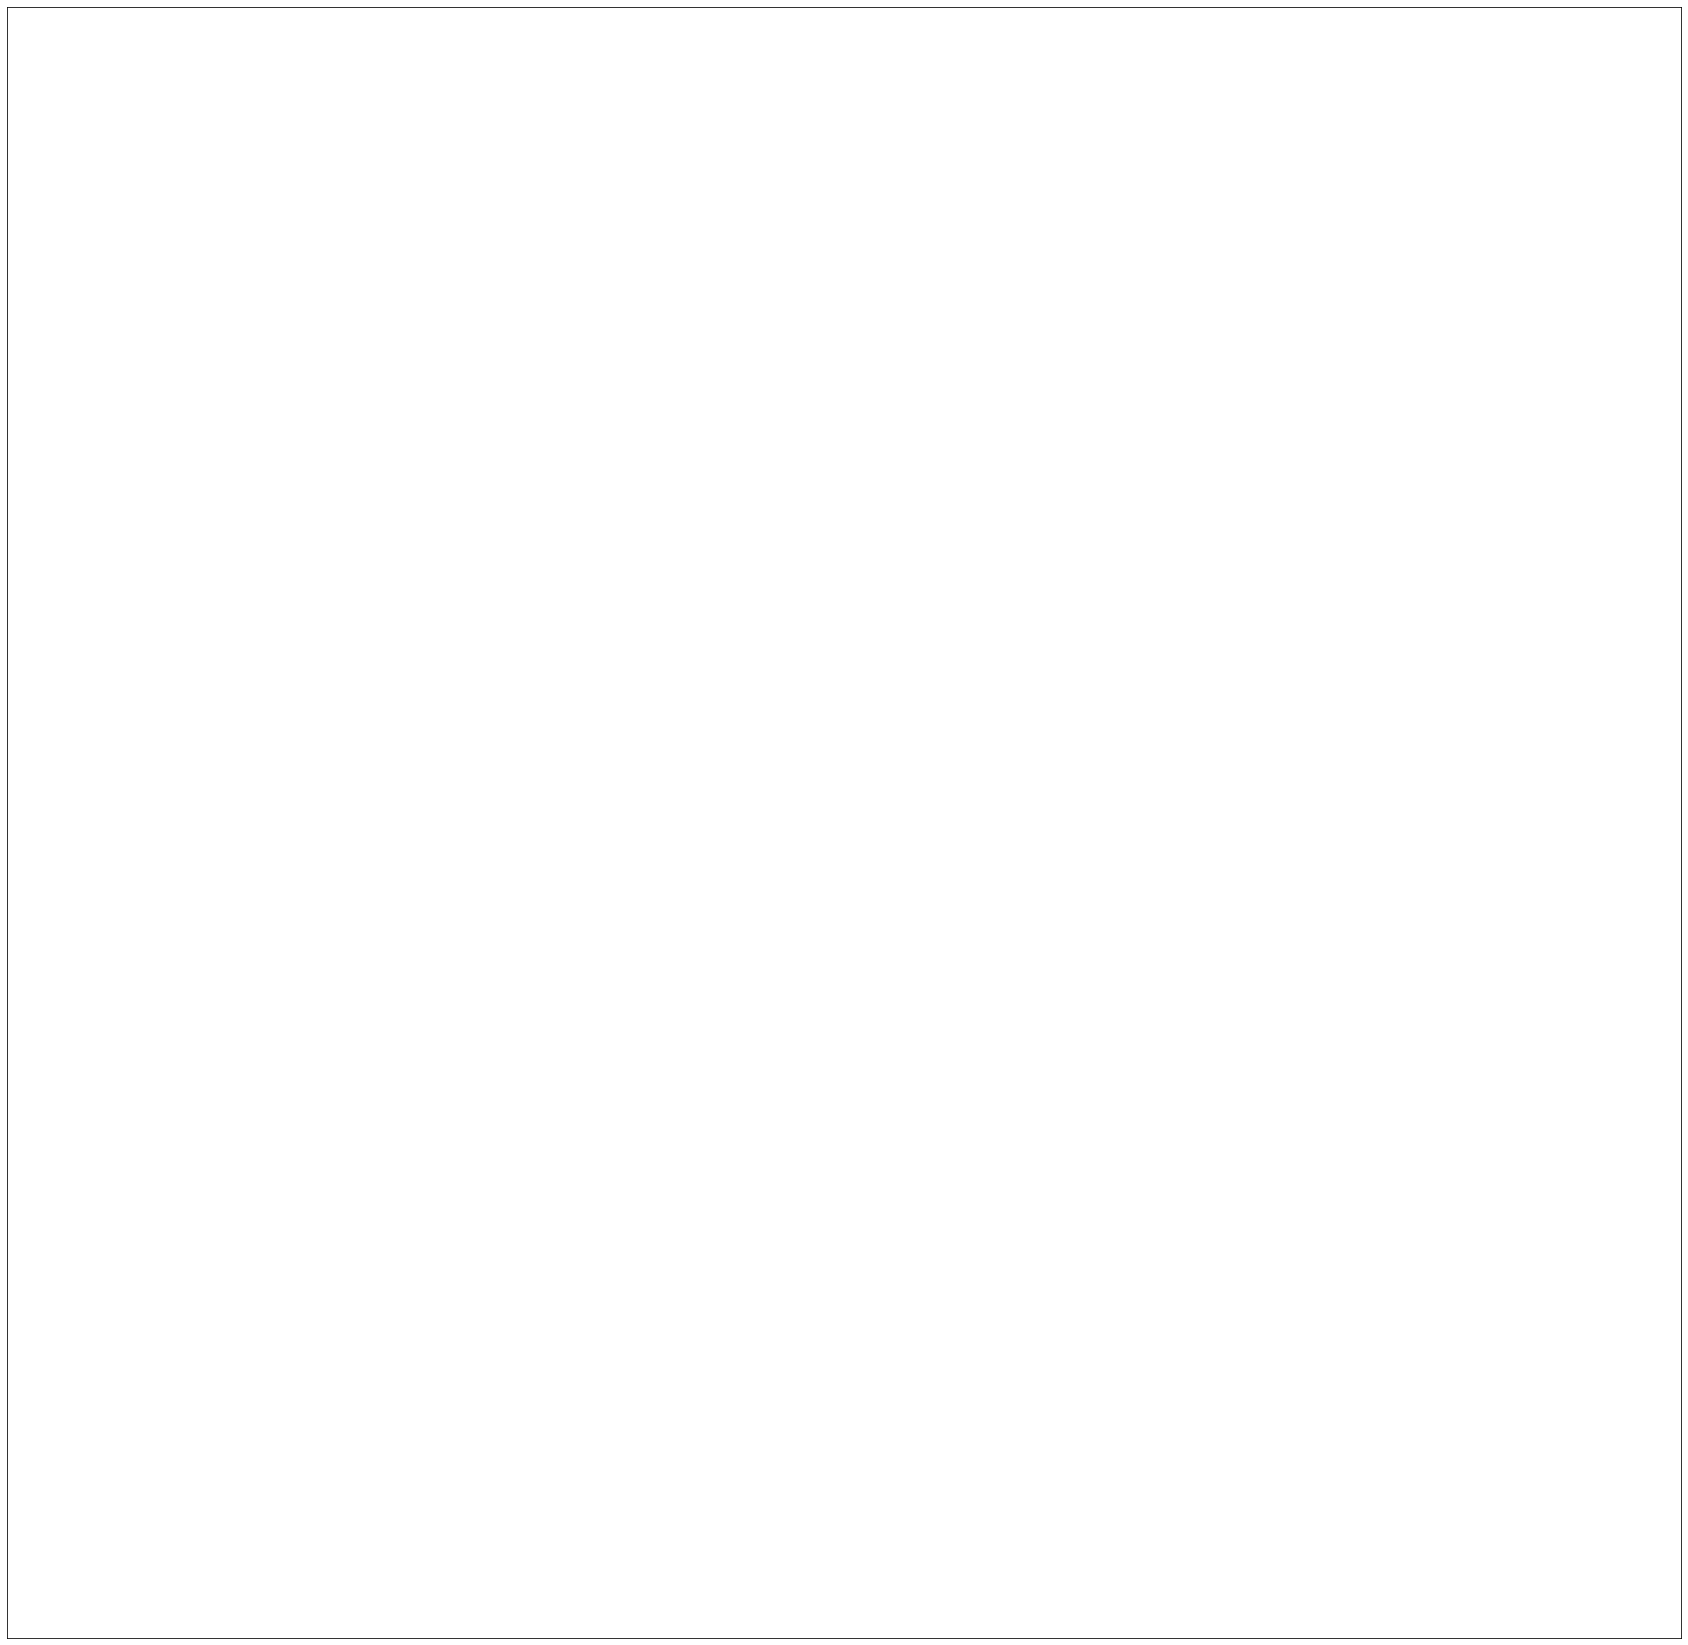

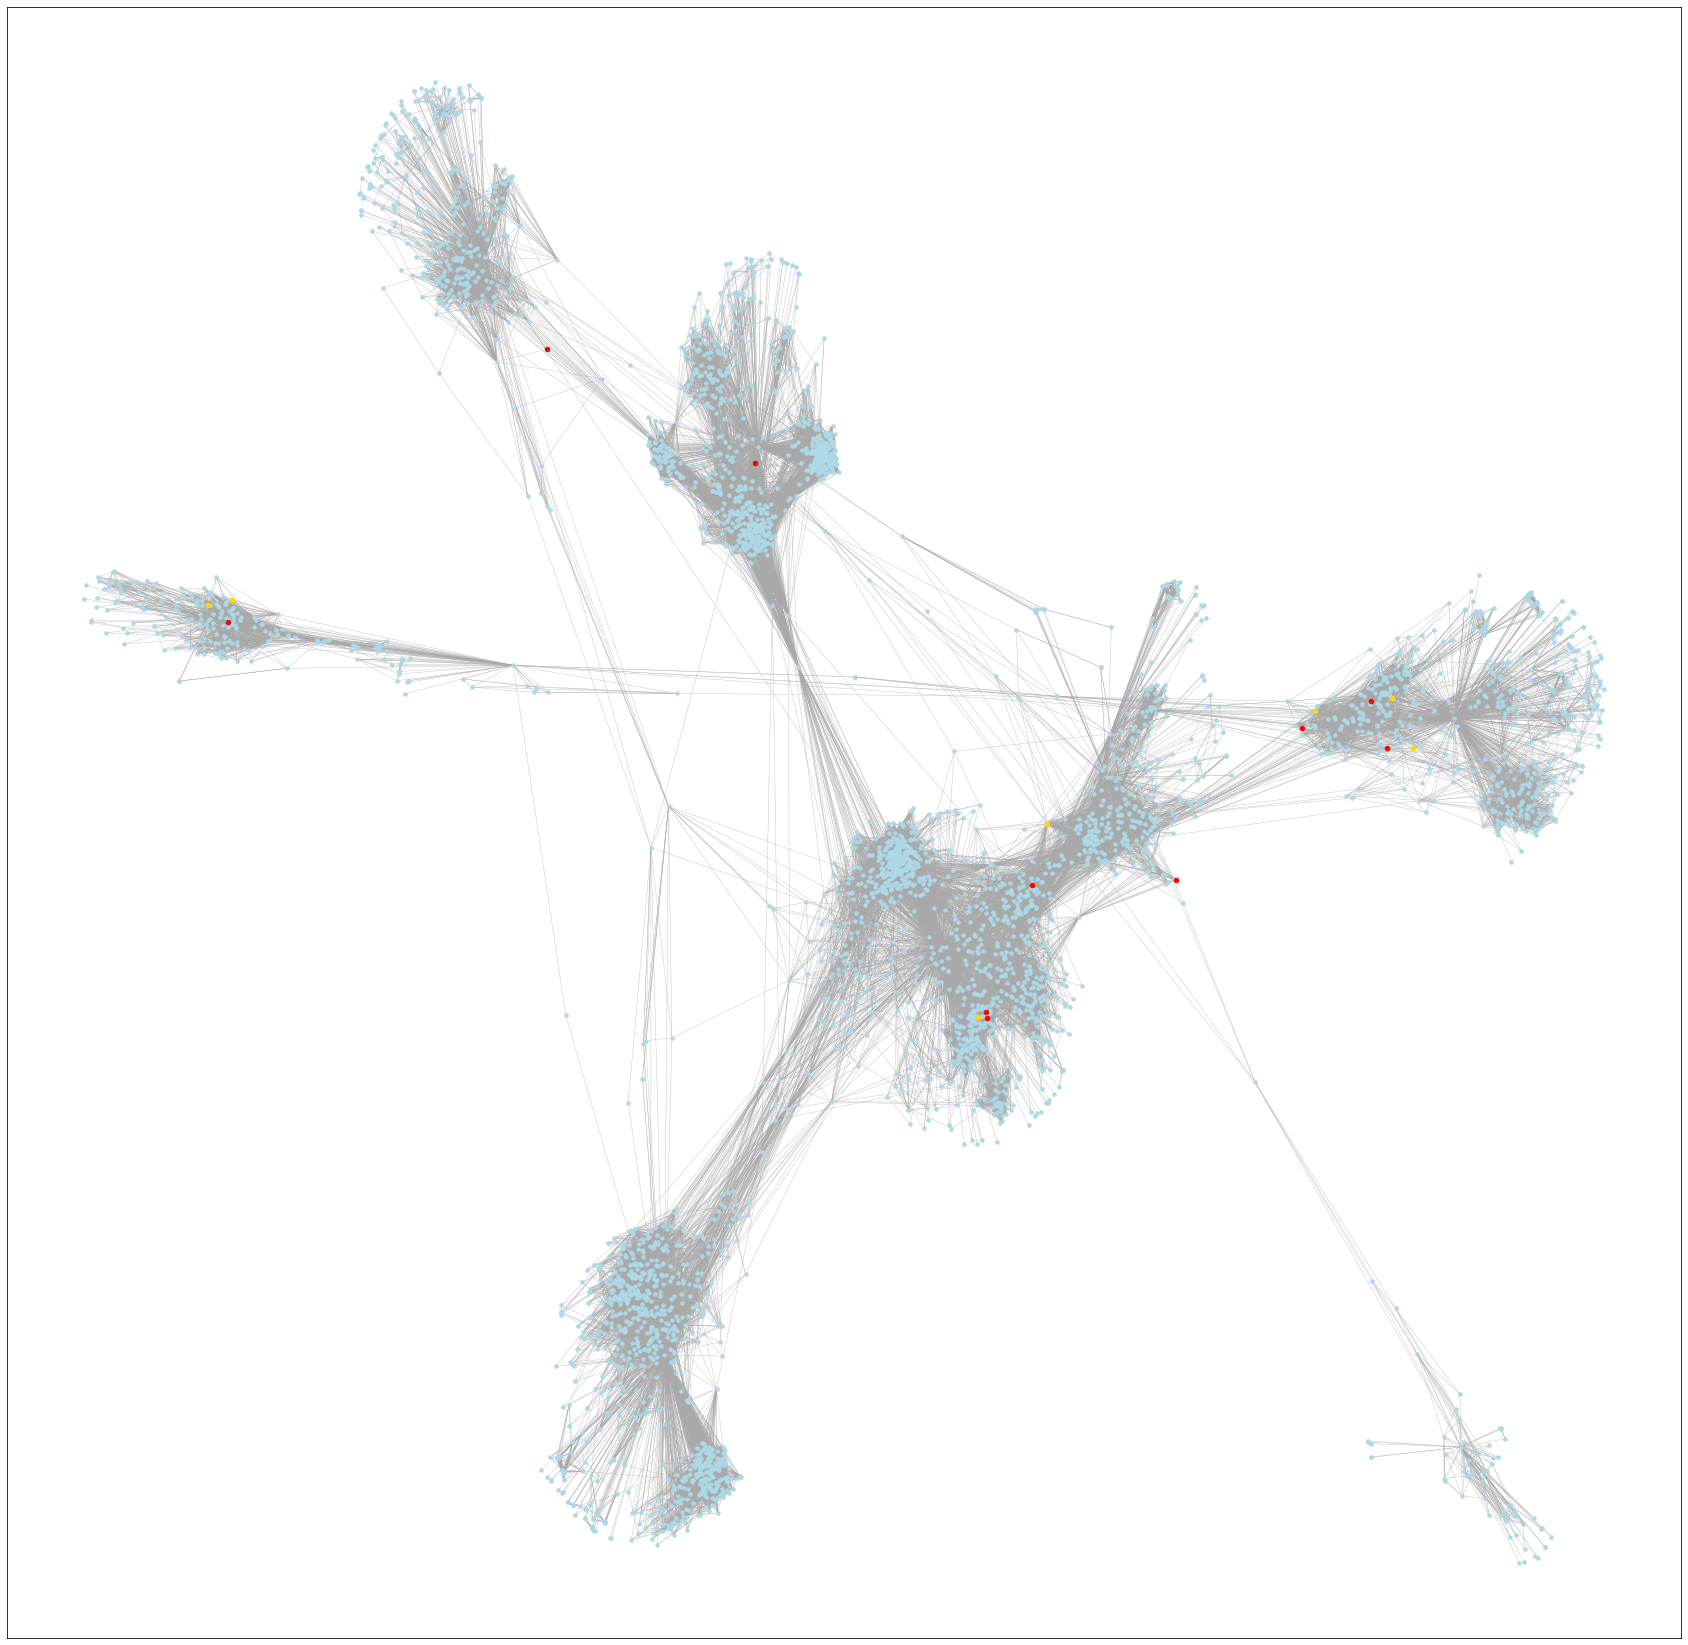

In [20]:
iteration = 0
for i in range(100):
    iteration += 1
    run_iteration(T_1, {'random': 1,'high_connect': 0, 'pooled': 0, 'most_infected': 0},)
    plt.cla()
    plt.figure(figsize=(30,30)) 
    size=12
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'S'],
                           node_color="#add8e6", node_size=size)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'E'],
                           node_color="#FFD700", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'I'],
                           node_color="#FF0000", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'R'],
                           node_color="#C8FFA2", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'H'],
                           node_color="#CC0000", node_size=20)
    nx.draw_networkx_nodes(T_1, pos,
                           nodelist=[n for n,v in T_1.nodes(data=True) if v['status'] == 'D'],
                           node_color="#800000", node_size=20)
    nx.draw_networkx_edges(T_1,pos,edge_color='#A9A9A9', width=0.3)
    plt.savefig("no_testing_" + str(iteration) + ".png")

In [53]:
# Store the number of infections

no_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
random_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(100)])
connect_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(50)])
infected_test_df = pandas.DataFrame(index = [i for i in range(50)], columns = [j for j in range(50)])

# Run each model for 50 time steps
print("Starting the no testing model")
for j in range(1):
    infected_num = []
    T = G.copy()
    first_infected = random.sample(list(T.nodes()), NUM_FIRST_INFECTED)
    for infected in first_infected:
        T.nodes[infected]["status"] = "I"
        T.nodes[infected]["days_since_E"] = 0
        T.nodes[infected]["days_since_I"] = 0
        T.nodes[infected]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
    for i in range(50):
        I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
        infected_num.append(len(I_n))
        run_iteration(T)
    no_test_df[j] = infected_num
    if j % 10 ==0:
        print("done", j, "iter")

print("Starting the random testing model")
for j in range(1):
    infected_num_random = []
    T_1 = G.copy() 
    first_infected = random.sample(list(T_1.nodes()), NUM_FIRST_INFECTED)
    for i in first_infected:
        T_1.nodes[i]["status"] = "I"
        T_1.nodes[i]["days_since_E"] = 0
        T_1.nodes[i]["days_since_I"] = 0
        T_1.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
    for i in range(50):
        I_n = [n for n,v in T_1.nodes(data=True) if v['status'] == 'I']
        infected_num_random.append(len(I_n))
        run_iteration(T_1, {'random': 1,'high_connect': 0, 'pooled': 0, 'most_infected': 0})
    random_test_df[j] = infected_num_random
    if j % 10 ==0:
        print("done", j, "iter")

print("Starting the testing highly connected people model")
for j in range(1):
    infected_num_connect = []
    T_2 = G.copy()
    first_infected = random.sample(list(T_2.nodes()), NUM_FIRST_INFECTED)
    for i in first_infected:
        T_2.nodes[i]["status"] = "I"
        T_2.nodes[i]["days_since_E"] = 0
        T_2.nodes[i]["days_since_I"] = 0
        T_2.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
    for i in range(50):
        I_n = [n for n,v in T_2.nodes(data=True) if v['status'] == 'I']
        infected_num_connect.append(len(I_n))
        run_iteration(T_2, {'random': 0,'high_connect': 1, 'pooled': 0, 'most_infected': 0})
    connect_test_df[j] = infected_num_connect
    if j % 10 ==0:
        print("done", j, "iter")
        
print("Starting the testing most infected people model")
for j in range(1):
    infected_num_infect = []
    T_4 = G.copy()
    first_infected = random.sample(list(T_4.nodes()), NUM_FIRST_INFECTED)
    for i in first_infected:
        T_4.nodes[i]["status"] = "I"
        T_4.nodes[i]["days_since_E"] = 0
        T_4.nodes[i]["days_since_I"] = 0
        T_4.nodes[i]["onset of symptoms"] = lognorm.rvs(size = 1, s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
    for i in range(50):
        I_n = [n for n,v in T_4.nodes(data=True) if v['status'] == 'I']
        infected_num_infect.append(len(I_n))
        run_iteration(T_4, {'random': 0,'high_connect': 0, 'pooled': 0, 'most_infected': 1})
    infected_test_df[j] = infected_num_infect
    if j % 10 ==0:
        print("done", j, "iter")
        

Starting the no testing model
done 0 iter
Starting the random testing model
done 0 iter
Starting the testing highly connected people model
done 0 iter
Starting the testing most infected people model
done 0 iter


In [9]:
#Basic parameter sweep for initial conditions 
param_sweep_df = pandas.DataFrame(index = [i for i in range(10)], columns = [j for j in range(11)])
for q_infectivity in range(11):
    starting_inf_list = []
    quarantine_infectivity = .1 * q_infectivity
    for starting_infected in range(10):
        NUM_FIST_INFECTED = 5 * (starting_infected + 1)
        trial_list = []
        for trial in range(20):
            print(q_infectivity, starting_infected, trial)
            T = G.copy()
            first_infected = random.sample(list(T.nodes()), NUM_FIRST_INFECTED)
            for infected in first_infected:
                T.nodes[infected]["status"] = "I"
                T.nodes[infected]["days_since_E"] = 0
                T.nodes[infected]["days_since_I"] = 0
                T.nodes[infected]["onset of symptoms"] = lognorm.rvs(size = 1, \
                     s=DIST_INCUBATION_SD, scale=np.exp(DIST_INCUBATION_MEAN))[0]
            for i in range(50):
                if i == 49:
                    I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
                    trial_list.append(len(I_n))
                run_iteration(T)
        starting_inf_list.append(statistics.mean(trial_list))
    param_sweep_df[q_infectivity] = starting_inf_list
    print(q_infectivity, "done")     

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 0 5
0 0 6
0 0 7
0 0 8
0 0 9
0 0 10
0 0 11
0 0 12
0 0 13
0 0 14
0 0 15
0 0 16
0 0 17
0 0 18
0 0 19
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 3 15
0 3 16
0 3 17
0 3 18
0 3 19
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 4 11
0 4 12
0 4 13
0 4 14
0 4 15
0 4 16
0 4 17
0 4 18
0 4 19
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 5 12
0 5 13
0 5 14
0 5 15
0 5 16
0 5 17
0 5 18
0 5 19
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 6 10
0 6 11
0 6 12
0 6 13
0 6 14
0 6 15
0 6 16
0 6 17
0 6 18
0 6 19
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 7 8
0 7 9
0 7 10
0 7 11
0 7 12
0 7 13
0 

6 2 15
6 2 16
6 2 17
6 2 18
6 2 19
6 3 0
6 3 1
6 3 2
6 3 3
6 3 4
6 3 5
6 3 6
6 3 7
6 3 8
6 3 9
6 3 10
6 3 11
6 3 12
6 3 13
6 3 14
6 3 15
6 3 16
6 3 17
6 3 18
6 3 19
6 4 0
6 4 1
6 4 2
6 4 3
6 4 4
6 4 5
6 4 6
6 4 7
6 4 8
6 4 9
6 4 10
6 4 11
6 4 12
6 4 13
6 4 14
6 4 15
6 4 16
6 4 17
6 4 18
6 4 19
6 5 0
6 5 1
6 5 2
6 5 3
6 5 4
6 5 5
6 5 6
6 5 7
6 5 8
6 5 9
6 5 10
6 5 11
6 5 12
6 5 13
6 5 14
6 5 15
6 5 16
6 5 17
6 5 18
6 5 19
6 6 0
6 6 1
6 6 2
6 6 3
6 6 4
6 6 5
6 6 6
6 6 7
6 6 8
6 6 9
6 6 10
6 6 11
6 6 12
6 6 13
6 6 14
6 6 15
6 6 16
6 6 17
6 6 18
6 6 19
6 7 0
6 7 1
6 7 2
6 7 3
6 7 4
6 7 5
6 7 6
6 7 7
6 7 8
6 7 9
6 7 10
6 7 11
6 7 12
6 7 13
6 7 14
6 7 15
6 7 16
6 7 17
6 7 18
6 7 19
6 8 0
6 8 1
6 8 2
6 8 3
6 8 4
6 8 5
6 8 6
6 8 7
6 8 8
6 8 9
6 8 10
6 8 11
6 8 12
6 8 13
6 8 14
6 8 15
6 8 16
6 8 17
6 8 18
6 8 19
6 9 0
6 9 1
6 9 2
6 9 3
6 9 4
6 9 5
6 9 6
6 9 7
6 9 8
6 9 9
6 9 10
6 9 11
6 9 12
6 9 13
6 9 14
6 9 15
6 9 16
6 9 17
6 9 18
6 9 19
6 done
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
7 0 5
7 0 6
7 0 7


In [11]:
param_sweep_df.to_csv("simulations/param_search.csv")

In [ ]:
no_test_df.to_csv("simulations/no_test_infected_quarentine.csv")
random_test_df.to_csv("simulations/random_test_infected_quarentine.csv")
connect_test_df.to_csv("simulations/connect_norm_test_infected_quarentine.csv")
infected_test_df.to_csv("simulations/infected_test_infected_quarentine.csv")

In [ ]:
S_n = [n for n,v in T.nodes(data=True) if v['status'] == 'S']
E_n = [n for n,v in T.nodes(data=True) if v['status'] == 'E']
I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
H_n = [n for n,v in T.nodes(data=True) if v['status'] == 'H']

In [ ]:
print(E_n)
print(I_n)
print(H_n)

In [ ]:
plt.plot([i for i in range(50)], infected_num[0:50], label = "Untested")
plt.plot([i for i in range(50)], infected_num_random[0:50], label = "Random testing")
plt.plot([i for i in range(50)], infected_num_connect[0:50], label = "Highest Connected testing")
plt.plot([i for i in range(50)], infected_num_infect[0:50], label = "Most Infected testing")

plt.legend()
plt.show()

50
[10]
done 0 iter
